# The goal is to generate a script to normalize our Sq measurements

Results: this attempt failed in the Sq/area output resulted in large temporal discrepancies as more regions of unrelated FLM membrane features increased the search area (X,Y). This exercise did allow for an method to output artificial models from vertice coordinates.

In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.surface import (surface_area, vertex_convexity)
from chimerax.map.volumecommand import volume
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   swapaxes, savetxt, column_stack,nansum, count_nonzero, nanstd)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure)
from scipy.spatial import KDTree
import numpy
import scipy
import matplotlib.pyplot as plt

In [ ]:
s= session
m= s.models
surface=m[1]
to_cell=m[3]
radius= 8
metric='RPD'
target ='sRBC'
size=(.1028,.1028,.1028)
palette=None
color_range= None
key=False
volume(session, voxel_size= size)

In [ ]:
if target == 'sRBC':
            target_r = 2.25
elif target =='mRBC':
            target_r = 3

In [ ]:
"""Define the target centroid from mid range x,y and z coordinates."""
centroid = mean(to_cell.vertices, axis=0)

"""Vertice x,y and z distances from centroid"""
x_coord, y_coord, z_coord = split(subtract(surface.vertices, centroid), 3, 1)

x_coord = x_coord.flatten()
y_coord = y_coord.flatten()
z_coord = z_coord.flatten()
"""Converting the cartisian system into spherical coordinates"""
z_squared = z_coord ** 2
y_squared = y_coord ** 2
x_squared = x_coord ** 2

distance = sqrt(z_squared + y_squared + x_squared)
distxy = sqrt(x_squared + y_squared)
theta = sign(y_coord)*arccos(x_coord / distxy)
phi = arccos(z_coord / distance)

"""Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
abovePhi = phi <= (pi/2)
radialClose = (distance  < radius) & (distance > target_r)

"""Outputs for coloring vertices as surface. arguments"""
radialDistanceAbovePhiLimitxy = abovePhi * radialClose * distance
surface.radialDistanceAbovePhiNoNans= abovePhi * radialClose * distance 
radialDistanceAbovePhiLimitxy[radialDistanceAbovePhiLimitxy == 0] = nan

surface.radialDistanceAbovePhi= abovePhi* distance
surface.radialDistanceAbovePhiLimitxy=radialDistanceAbovePhiLimitxy

surface.radialDistance = distance
surface.theta = theta
surface.phi = phi

In [ ]:
"""Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
abovePhi = phi <= (pi/2)
radialClose = (distance  < radius) & (distance > target_r)

"""Single value outputs for definning topology"""
surface.IRDFCarray = nanmean(radialDistanceAbovePhiLimitxy)
surface.Sum = nansum(radialDistanceAbovePhiLimitxy)
""" surface.area = surface_area(vertices, triangles) """

surface.area = count_nonzero(surface.radialDistanceAbovePhiNoNans)
surface.ArealRoughness = sqrt(surface.IRDFCarray**2/(2*pi*target_r**2))
surface.ArealRoughness_STD = nanstd(surface.radialDistanceAbovePhiLimitxy)/(2*pi*target_r**2)

In [ ]:
"""    elif metric == 'rpd' and hasattr(surface, 'radialDistanceAbovePhiNoNans'):"""
measurement = surface.radialDistanceAbovePhiNoNans
palette_string = 'purples'
max_range = 10

In [ ]:
if isnan(measurement).all():
    measurement[:] = 0

if palette is None:
    palette = colors.BuiltinColormaps[palette_string]

if color_range is not None and color_range != 'full':
    rmin, rmax = color_range
elif color_range == 'full':
    rmin, rmax = nanmin(measurement), nanmax(measurement)
else:
    rmin, rmax = (0, max_range)

In [ ]:
cmap = palette.rescale_range(rmin, rmax)
surface.vertex_colors = cmap.interpolated_rgba8(measurement)

In [ ]:
search=distxy*abovePhi*radialClose
fig= plt.figure()

ax = fig.add_subplot()

ax.scatter(theta,search)
ax.set_title('Scatter plot of points: theta, search')
ax.set_xlabel('theta')
ax.set_ylabel('search')
plt.show()

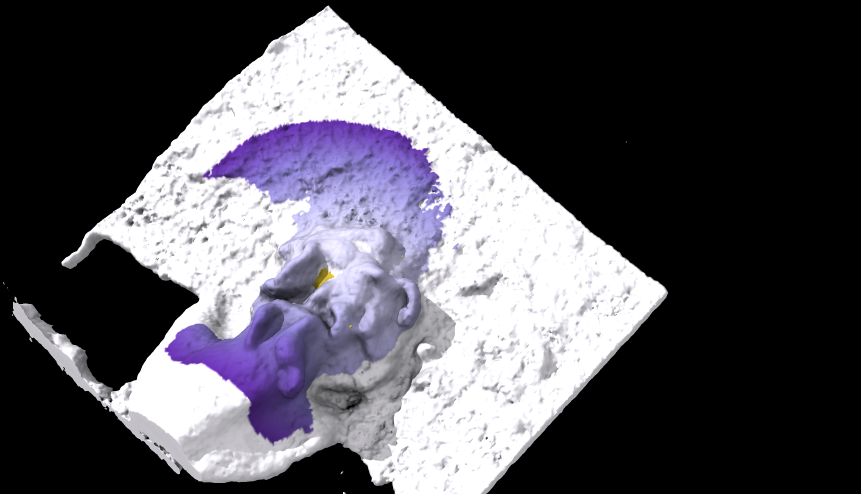

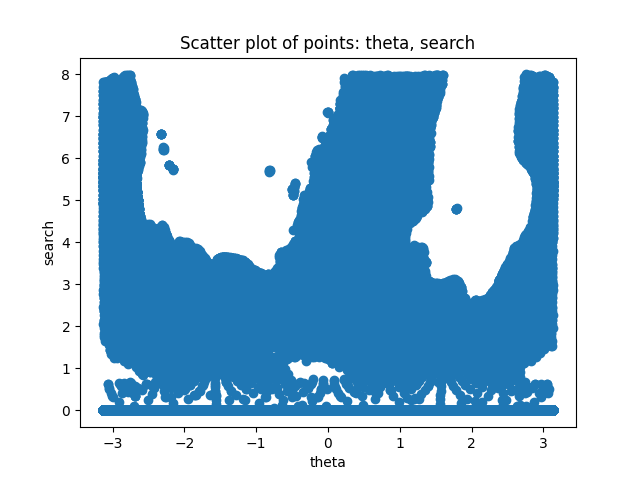

###mRBC case to demo. Observed problem is generalizable.

Douplicate case on mRBC
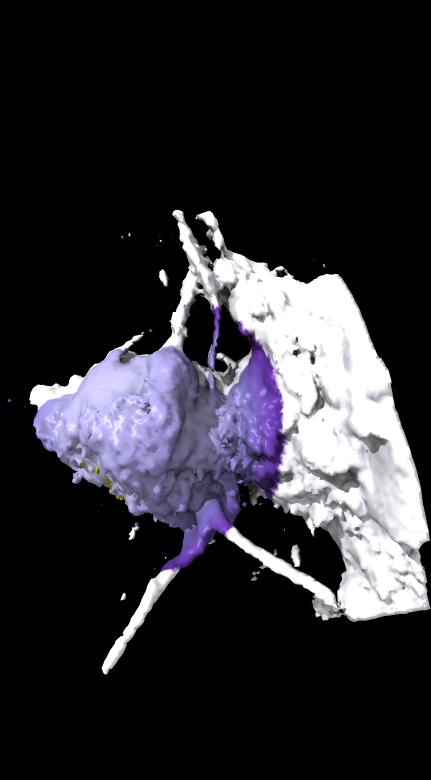

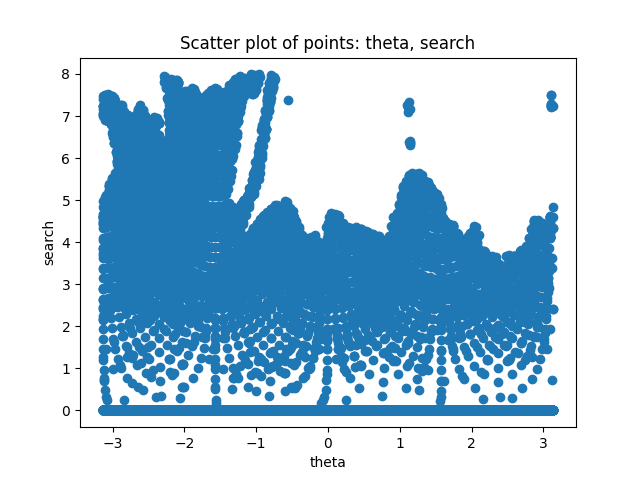

Will need to solve a way to esentially, make a 2d mask of the search area, detect the edges, solve for the search area.

Testing the cause with a binary mask generated by yours truely

In [ ]:
test = numpy.zeros((128,128))
test[50:100,50:100]=1

from scipy.ndimage import gaussian_laplace as gl
edge=gl(test,sigma=1)
e=edge*edge[::]>0
'set to current working directory. change path as needed'
numpy.savetxt('testEdgeFinding.txt',e,delimiter=',')


plt.imshow(test, cmap='binary')
plt.imshow(e, cmap='Greens',alpha=.5)
plt.title('Edge finding-50xSq, 128x128 Region sigma=1')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.legend()
plt.show()

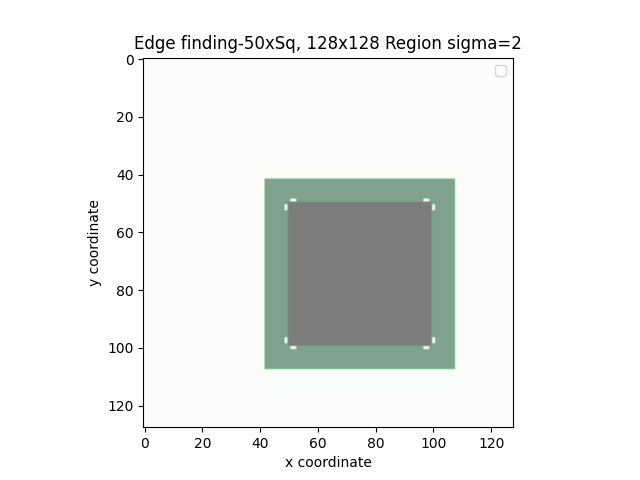


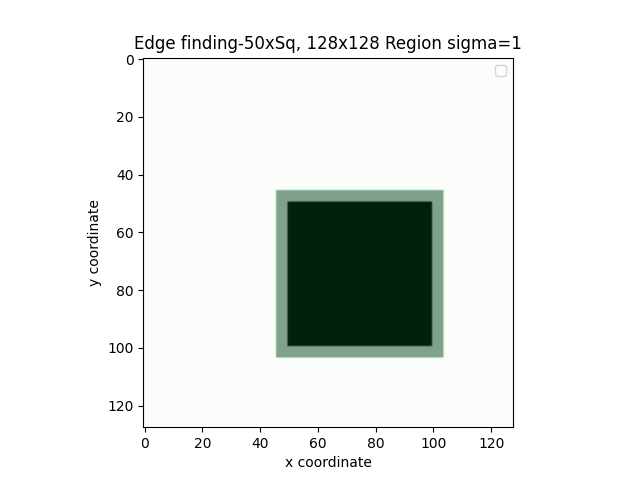

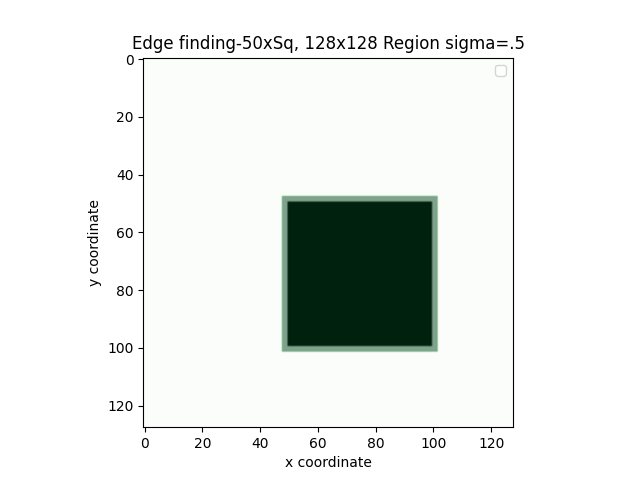

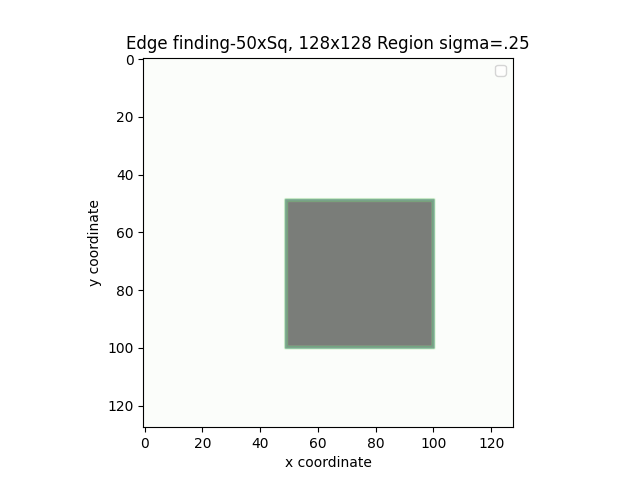

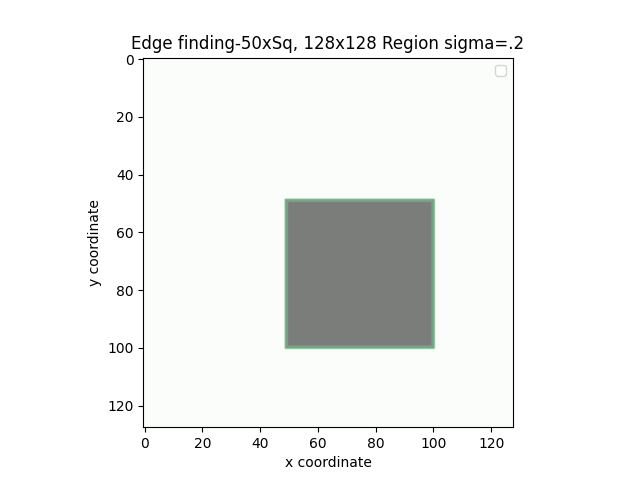

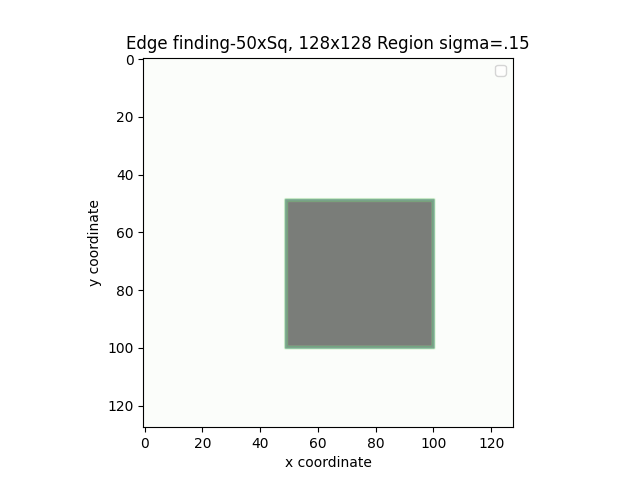

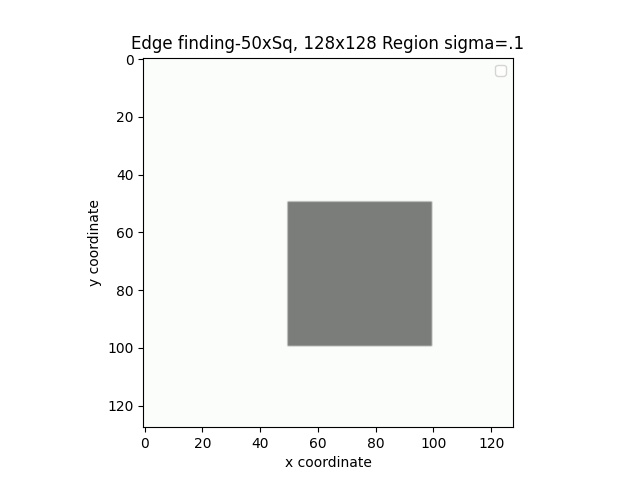

Sigma = 0.1 yeilds not masking

Theoretically this method can be applied on data where I will attempt to generate a single plane where we have objects in our search and running the dge detection on it.

In [ ]:
search=distxy*abovePhi*radialClose
s=search>0

xx=x_coord*s
yy=y_coord*s

xy=numpy.unique(numpy.column_stack((xx,yy)),axis=0)

This current method does not care if duplicate vertices are sitting on one another in the "flattened" image

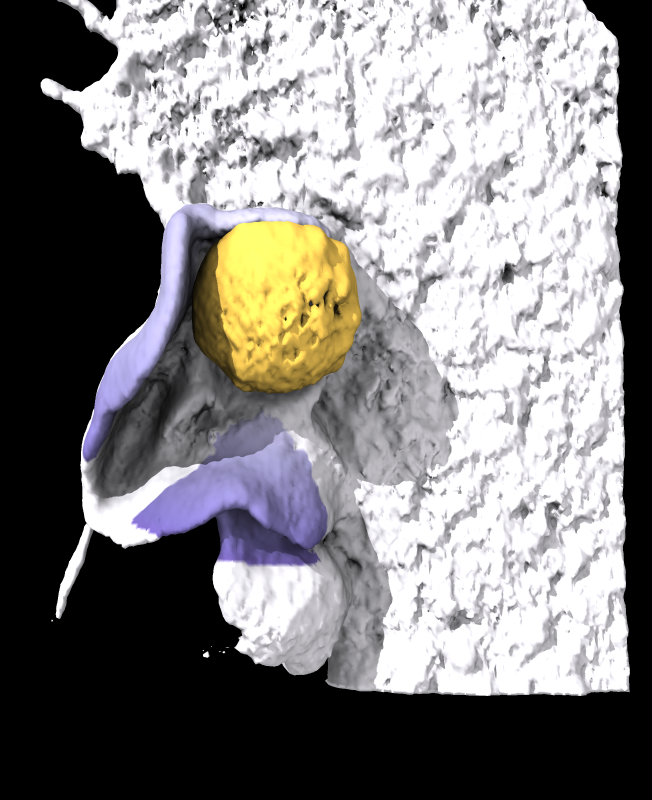

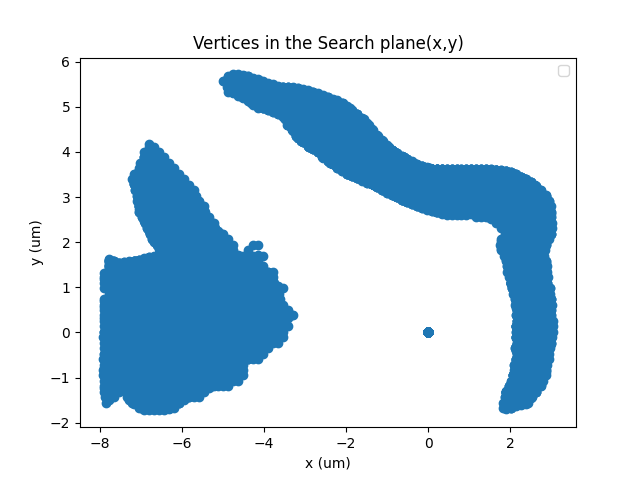

Running the edge detection on this data

In [ ]:


numpy.shape(x_coord)
'''Out[237]: (154670,)'''

numpy.shape(xx)
'''Out[238]: (154670,)'''
numpy.shape(xy)
'''Out[239]: (7761, 2)'''



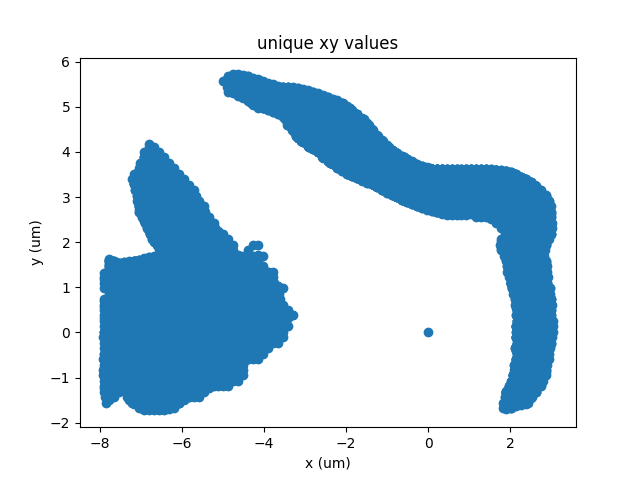

In [ ]:
big=xy*(10e10)

bigint=numpy.int32(big)

bigint.any() != big.any()
'''Out[345]: False'''

![blowing up image.png](<attachment:blowing up image.png>)
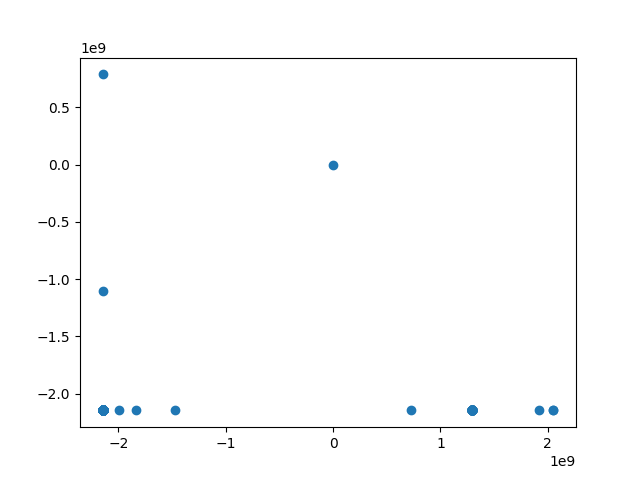

In [ ]:
numpy.max(big)
'''Out[364]: 571905600000.0'''

big=xy*(1e10)

bigint=numpy.int64(big)

![blowing up imageint62.png](<attachment:blowing up imageint62.png>)
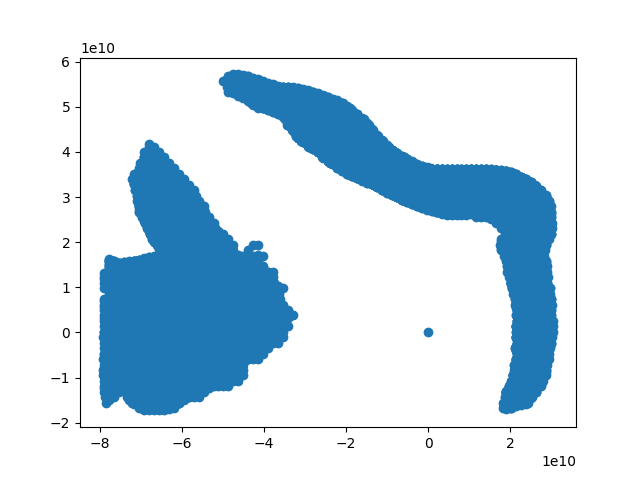

big_max=numpy.max(bigint,axis=0)
big_min=numpy.min(bigint,axis=0)


stepsz = (big_max-big_min)/((numpy.count_nonzero(xy))*1e10)
'''Out[384]: array([0.00070771, 0.00047988])'''

'''Above script does not work as intended''

''moving on to the idead of groupping data

This is not what I should be doing for solving my problem

In [ ]:
width = size[1]
steps = numpy.int64(numpy.round_(numpy.abs((2*radius)/(width))))
bins = numpy.digitize(xy[:,0],numpy.linspace(-8,8,steps))

minBin = numpy.zeros((numpy.max(bins),1))
maxBin = numpy.zeros((numpy.max(bins),1))
for i in range (numpy.min(bins), numpy.max(bins)):
    indexedBin= numpy.where(bins == i)
    Check = numpy.size(indexedBin)
    if Check != 0:
        minBin[i,0] = numpy.min(xy[indexedBin ,1])
        maxBin[i,0] = numpy.max(xy[indexedBin ,1])
    else:
        minBin[i,0] = 0
        maxBin[i,0] = 0 

This is not what I need to calculate I'll need the relative maxs and mins per bin.

Scipy.signal.argrelmin and max output two arrays of the max or min's location in you array (row,col)

##SessionNotes##

open X:/Phagocytosis/sRBC/20190614cs1/track_3/Cell_CamB_ch0_stack0050_488nm_0376490msec_0004064137msecAbs_decon.tif;
open X:/Phagocytosis/sRBC/20190614cs1/track_3/Cell_CamA_ch1_stack0050_560nm_0376490msec_0004064137msecAbs_decon.tif;

volume #2 style surface level 118 color #ffd059
volume #1 style surface level 73 color #2b5884

lighting full; 
lighting depthcue false;
material dull; 
surface dust #1,2 metric "volume rank" size 1 ;
ui tool show Shell;

I have been working in a single window and make adjustments like a dingus


In [ ]:
area
Out[121]: 
array([ 0.12080002,  0.12080002,  0.8456001 , -0.6040001 , -0.24160004,
        0.4959154 ,  0.12080002,  0.10221481,  0.24159908,  0.12080002],
      dtype=float32)

maxHxs
Out[122]: 
array([-0.35758018,  0.00481987,  0.97122   ,  0.48801994, -0.8407793 ,
       -1.190464  , -0.8407793 , -0.6177645 , -0.35758018,  0.12561989],
      dtype=float32)

minHxs
Out[123]: 
array([-0.4783802 , -0.11598015,  0.12561989,  1.09202   , -0.59917927,
       -1.6863794 , -0.9615793 , -0.7199793 , -0.59917927,  0.00481987],
      dtype=float32)

xy[indexedBin ,1]
Out[124]: 
array([[ 1.5752201 , -1.3239794 , -0.8407793 , -1.0823793 , -1.3239794 ,
        -0.7199793 , -1.3239794 , -0.8407793 ,  1.4544201 , -1.4447794 ,
        -0.8407793 , -1.3239794 , -1.4447794 , -0.8407793 , -0.59917927,
        -1.4931002 , -1.4674301 , -1.4518852 , -1.4447794 , -1.3757515 ,
        -1.3737211 , -1.3659973 , -1.3344841 , -1.3239794 , -1.2877398 ,
        -1.2389727 , -1.2031794 , -1.1226463 , -1.0823793 , -0.9615793 ,
        -0.9011793 , -0.87852955, -0.8407793 , -0.83367443, -0.8206463 ,
        -0.7763529 , -0.7703123 , -0.7672491 , -0.7360859 , -0.7199793 ,
        -0.6797123 , -0.6509514 , -0.63944626, -0.59917927, -0.5939274 ,
        -0.4783802 , -0.39113522, -0.35758018, -0.23678017, -0.11598015,
         0.00481987,  0.12561989,  0.21286488,  0.2464199 ,  0.36721992,
         0.4638605 ,  0.48801994,  0.5618429 ,  0.60881996,  0.72962   ,
         0.7417002 ,  0.85042   ,  0.94279766,  0.97122   ,  1.011487  ,
         1.09202   ,  1.1109686 ,  1.1942358 ,  1.21282   ,  1.24302   ,
         1.3336201 ,  1.4302607 ,  1.4519548 ,  1.4544201 ,  1.5027409 ,
         1.5159607 ,  1.5567932 ,  1.5629358 ,  1.5737295 ,  1.5752201 ,
         1.585082  ,  1.5903206 ,  1.6007748 , -0.59917927, -0.7199793 ,
        -0.8407793 ,  1.5752201 , -1.4447794 , -0.59917927, -1.5655794 ,
        -0.59917927,  1.4544201 , -0.35758018, -0.7199793 , -1.4447794 ,
        -0.7199793 ,  0.97122   , -1.5655794 ]], dtype=float32)

XY[x,y] is not sorted for the Y values but their x. The binning is accurate where we say for bins that fall in the ~ the same pixel width are to be grouped. 

Area compairisons are not accurate in the above script. 

In [ ]:
ymax=xy[(scipy.signal.argrelmax(xy[indexedBin ,1],axis=1)[1]),1]

numpy.ndarray.sort(ymax)

ymax
Out[132]: 
array([-1.190464  , -0.8407793 , -0.8407793 , -0.6177645 , -0.35758018,
       -0.35758018,  0.00481987,  0.12561989,  0.48801994,  0.97122   ],
      dtype=float32)


ymin=xy[(scipy.signal.argrelmin(xy[indexedBin ,1],axis=1)[1]),1]

numpy.ndarray.sort(ymin)

ymin
Out[133]: 
array([-1.6863794 , -0.9615793 , -0.7199793 , -0.59917927, -0.59917927,
       -0.4783802 , -0.11598015,  0.00481987,  0.12561989,  1.09202   ],
      dtype=float32)

area=ymax-ymin

area
Out[137]: 
array([ 0.4959154 ,  0.12080002, -0.12080002, -0.01858521,  0.24159908,
        0.12080002,  0.12080002,  0.12080002,  0.36240005, -0.12080002],
      dtype=float32)

sum(area)

I need to sort the array then move it into maxima search

In [ ]:
width = size[1]
steps = numpy.int64(numpy.round_(numpy.abs((2*radius)/(width))))
bins = numpy.digitize(xy[:,0],numpy.linspace(-8,8,steps))

area = numpy.zeros((numpy.max(bins),1))
for i in range ( numpy.min(bins),numpy.max(bins) ):
    indexedBin= numpy.where(bins == i)
    Check = numpy.size(indexedBin)
    if Check != 0:
        tosort=xy[indexedBin ,1]
        s= numpy.argsort(tosort,axis=1)
        Sorted=numpy.unique(tosort[0,s])
        maxHxs = xy[(scipy.signal.argrelmax(Sorted,axis=1)[1]),1]
        minHxs = xy[(scipy.signal.argrelmin(Sorted,axis=1)[1]),1]        
        area[i,0] = numpy.sum(maxHxs - minHxs)
    else:
        area[i,0] = 0
    return area

Has to use argsort and not sort

ValueError                                Traceback (most recent call last)
Cell In[152], line 10
      8     maxHxs = xy[(scipy.signal.argrelmax(Sort,axis=1,order=5)[1]),1]
      9     minHxs = xy[(scipy.signal.argrelmin(Sort,axis=1,order=5)[1]),1]        
---> 10     area[i,0] = numpy.sum(maxHxs - minHxs)
     11 else:
     12     area[i,0] = 0

It's stating that one array is larger thant he other on i=2

In [ ]:
(scipy.signal.argrelmax(Sorted,axis=1,order=10)[1])

In [ ]:
xy[(scipy.signal.argrelmax(xy[indexedBin ,1],axis=1)[1]),1]

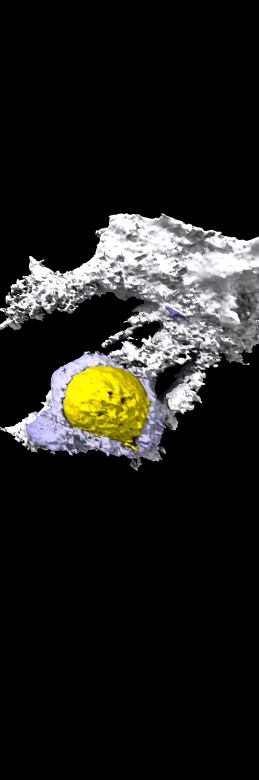

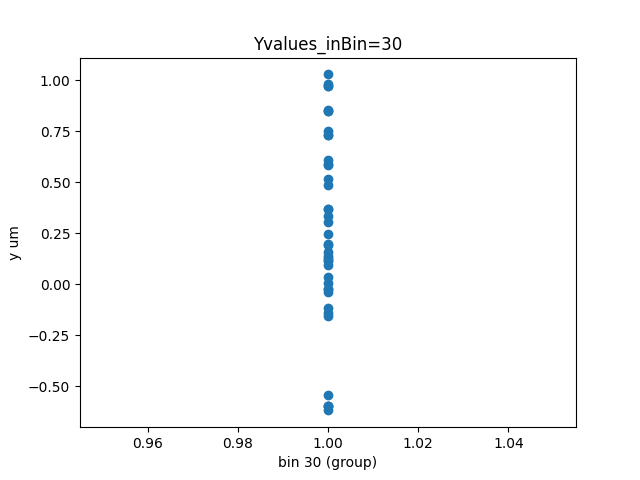

This methods is bound to fail must find another method for approaching this problem

---Fresh attempt--
--Concept: I can bin vertice location along one axis (x-axis) via indexing in numpy. Then if I retain all unqiue positions per bin and sort the result I can bin all locations in the opposing axis (y-xis). This allows for a method to reconstruct the original pixel locations and should allow for the reconstruction of a 2D flattened matrix representing the 2D coverage for the search. From this artificial image I can simply sum all point corrosponding to the physical pixal size of the camera and output the search area to normalize our result. 

In [ ]:
"""Defining the pixel size from human defined parameter"""
width = size[1]
"""Defining steps that will are approximately one pixel in length"""
steps = numpy.int64(numpy.round_(numpy.abs((2*radius)/(width))))
"""Indexing the vertices that fall in one pixel of eachother along each axis""" 
xbins = numpy.digitize(xy[:,0],numpy.linspace(-8,8,steps))
ybins = numpy.digitize(xy[:,1],numpy.linspace(-8,8,steps))
"""Making an artificial binary image"""
ArtImg=numpy.zeros([steps,steps])
ArtImg[xbins,ybins]=1

plt.imshow(ArtImg, cmap='binary')
plt.title('Scatter plot of Artificial Image (x,y) values')
plt.xlabel('x um')
plt.ylabel('y um')
plt.show()

General shap matches the xy coordinate plot. Needs to be refined before it can be implimented.

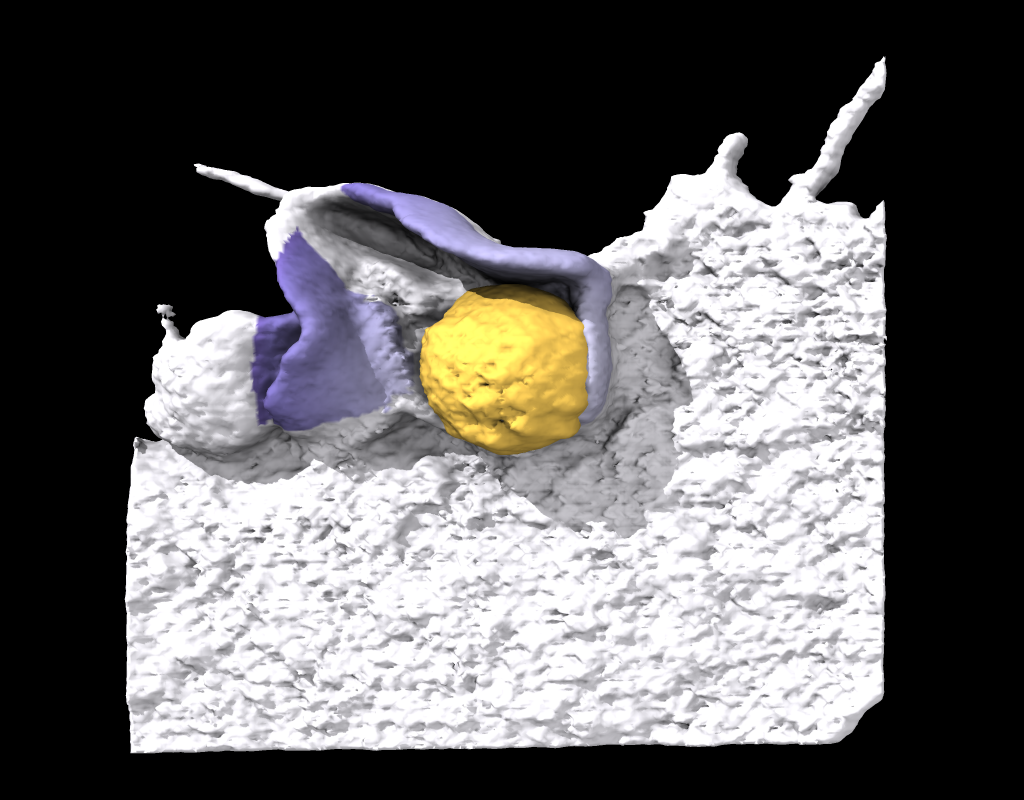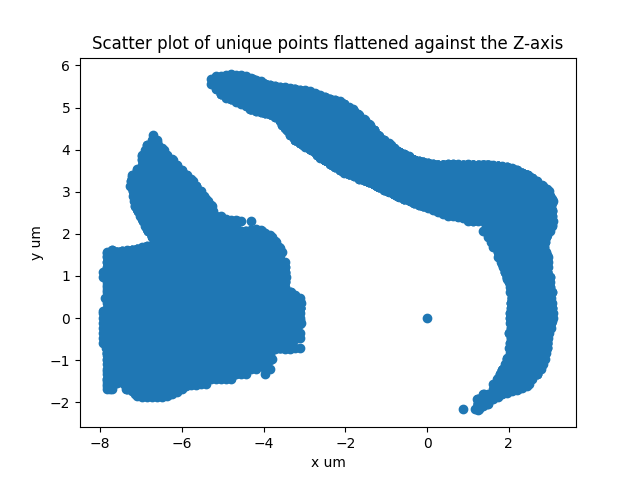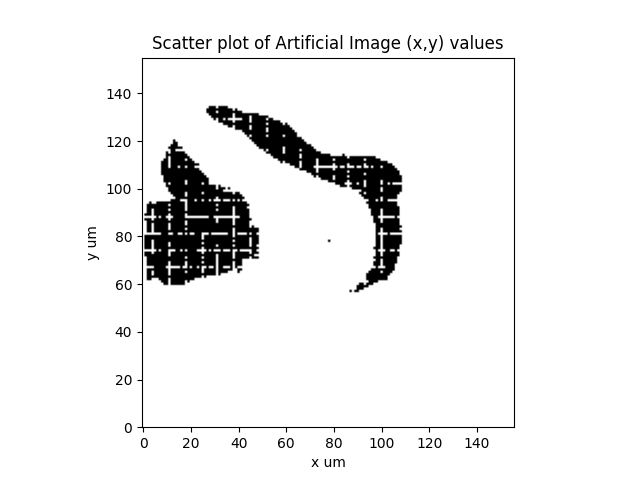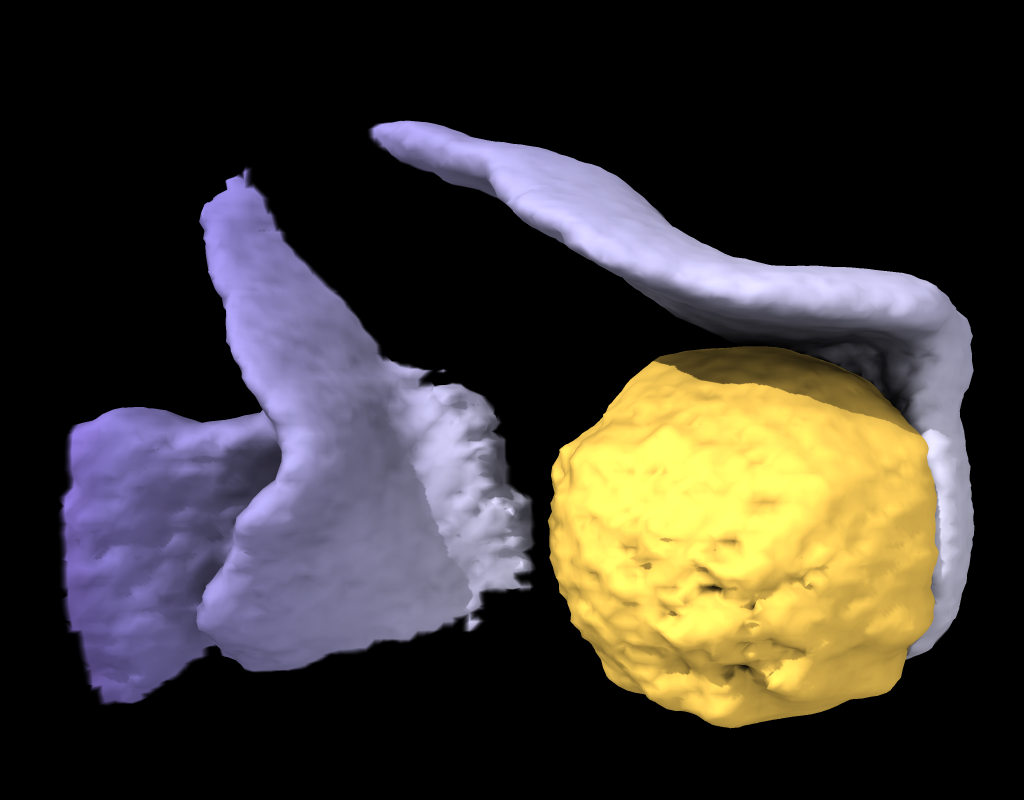

Data being plotted in the artificial image is the vertices and there is no guarantee these points will always line up with the true values since ChimeraX determination for smoothing and supersampling likely modulates these values slightly.

Impression:
    -this is a 16 micron scare that corolates to the search area (2d plane fo the 3d hemisphere)
    -Center is documented at ~80 pixels 
    -extra dot in the center is an artifact from the 
        -search=distxy*abovePhi*radialClose
        -s=search>0

        -xx=x_coord*s
        -yy=y_coord*s

        -xy=numpy.unique(numpy.column_stack((xx,yy)),axis=0)
        
        -Setting things not in the search to 0 results in a (x,y) (0,0) center point. If -i set to nan value this can fix this artifact.
    

Guassian - erodes 

In [ ]:
glerode=scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1)
glerodes=scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=2)

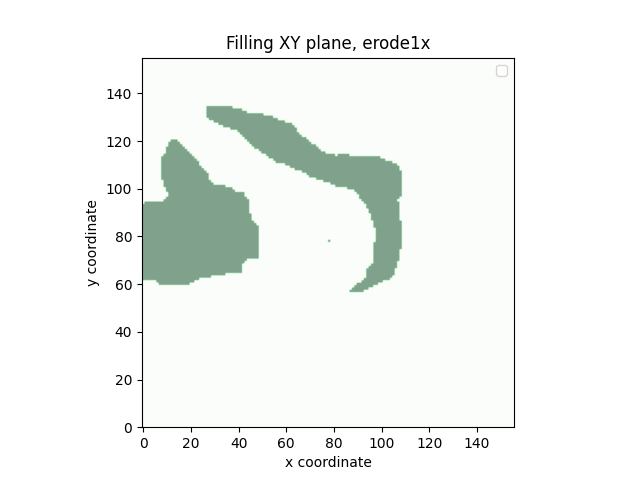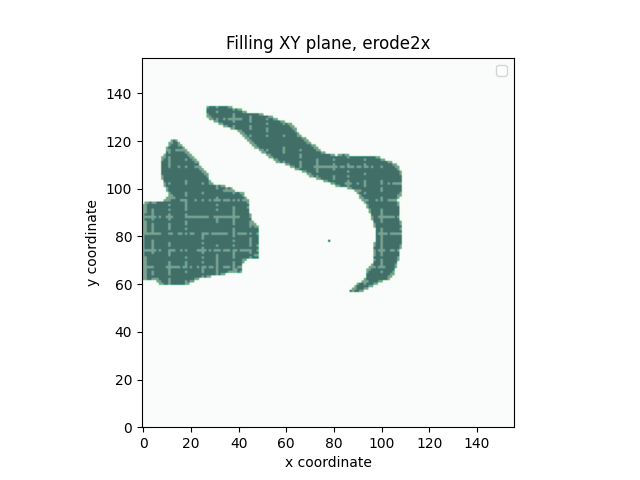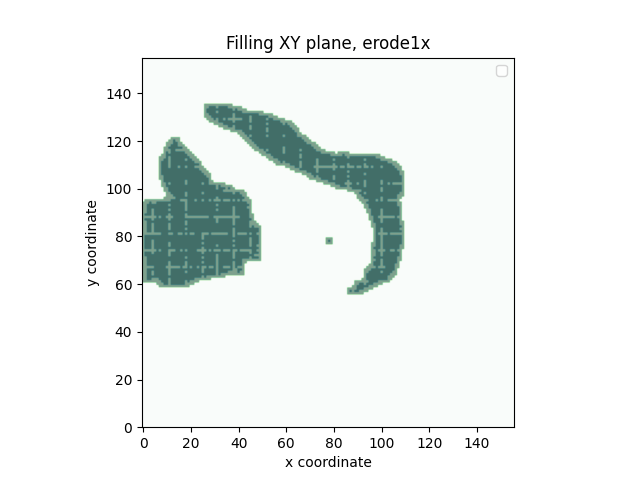!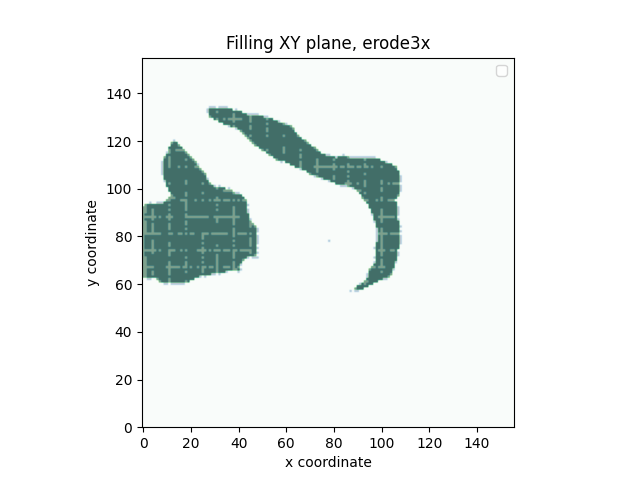

In [ ]:
numpy.count_nonzero(glerode)
Out[223]: 4027

numpy.count_nonzero(glerodes)
Out[224]: 3607

numpy.sum(glerode)*(0.1028**2)
Out[227]: 42.55669168

numpy.sum(glerodes)*(0.1028**2)
Out[228]: 38.11819888

numpy.sum(glerodess)*(0.1028**2)
Out[233]: 33.89106288

In [ ]:
Area_Search=numpy.count_nonzero(scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=3)) * (size[1]**2)

Area_Search
Out[239]: 33.89106288

Area_Search=numpy.count_nonzero(scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=3)) * (size[1]*size[1])

Area_Search
Out[241]: 33.89106288

Impliment such that anyone can use this given that they state their voxel size in x,y,z 

In [ ]:
Area_Search=numpy.count_nonzero(scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=3)) * (size[1]*size[2])

Area_Search
Out[243]: 33.89106288